In [1]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import matplotlib as mpl 
from scipy.sparse import load_npz
import ujson as json
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.utils import check_random_state
from tqdm.notebook import tqdm


# para MinMax Scaler
sup_min_bubble_size = 0
sup_max_bubble_size = 70

sns.set(style='ticks', palette='magma', context='notebook', font='Linux Biolinum O')
#%config InlineBackend.figure_format = 'retina'
%matplotlib inline


    
def normalize_dataframe_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def plot_component(column, **kwargs):
    df = kwargs.pop('data')
    ax = plt.gca()
    #urban_context.plot(ax=ax, facecolor='#efefef', edgecolor='#cfcfcf')
    #highways.plot(ax=ax, color='#333333', linewidth=1)
    #primary.plot(ax=ax, color='orange', linewidth=1)
    #cycleways.plot(ax=ax, color='lime', linewidth=1)

    scaler = kwargs.pop('scaler', None)
    sizes = scaler.transform(np.sqrt(df[column].values.reshape(-1, 1)))
    ax.scatter(df.geometry.x, df.geometry.y, s=sizes, color='#4B0082', alpha=0.5, zorder=20)
    plt.axis('off')
    plt.axis('equal')
    

def plot_modal_partition(flow_posteriors, period, title, save_as=False):
    flow_trips = flow_posteriors#.mul(period_matrices.loc[period], axis='index')

    (flow_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('bus')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title(title + ', ' + period)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()
    if save_as:
        plt.savefig(save_as, bbox_inches = 'tight')
        plt.clf()
        plt.close()
    else:
        plt.show()


def plot_heatmap(posteriors,mode_of_transportation, title, save_as=None):
    heatmap = (posteriors.join(zones.Comuna, on='origin_zone').rename(columns={'Comuna' : 'Comuna_origen'})
               .join(zones.Comuna, on='destination_zone').rename(columns={'Comuna' : 'Comuna_destino'})
               .groupby(['Comuna_origen', 'Comuna_destino']).agg('sum')[mode_of_transportation]
               .unstack(fill_value=0).pipe(normalize_dataframe_rows)
              )
    plt.figure(figsize=(15,12))
    sns.heatmap(heatmap, linewidth=1, cmap='magma_r', annot=False, vmin=0, vmax=1, cbar_kws={"shrink": 0.5, "label" : "Trips fraction"})
    plt.title(title + '. Mode of transportation = ' + mode_of_transportation)
    if save_as!=None:
        plt.savefig(save_as, bbox_inches = 'tight')
        plt.clf()
        plt.close()
    else:
        plt.show()

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importamos el id, area, la comuna a que pertenece y la geometria
zones = gpd.read_file('json/urban_zones_2016.json').set_index('ID').to_crs({'init': 'epsg:5361'})
# Distancias entre un origen y un destino
zone_distances = pd.read_csv('2017_results/zone_distances.csv.gz', index_col=['ZonaOrigen', 'ZonaDestino'])
# Periodo en el que se realizo el viaje
zone_matrix = pd.read_json('2017_results/od_matrix_per_zone.json.gz', lines=True)
period_matrices = zone_matrix.groupby(['period', 'origin_zone', 'destination_zone'])['trip_count'].mean()
# Media de Ingresos por Hogar segun zona
zone_income = pd.read_csv('2017_results/zone_income.csv.gz', index_col='Zona')
# Distancia Minima
zone_mindist  = np.sqrt(pd.read_csv('2020_results/mindist_zonahogar.csv', index_col='Zona'))

In [3]:
# Torres de telefonía ya etiquetadas
towers =  gpd.read_file('2017_results/towers_with_labels.geo.json').set_index('tower')
# Puntos de referencia entre zonas
waypoints = load_npz('2017_results/waypoints_between_zones.npz')
waypoint_index = pd.read_json('2017_results/waypoints_between_zones_index.json.gz', lines=True)
periods = waypoint_index.period.unique()
# Hora peak mañana y tarde
#relevant_periods = ['morning_peak_1', 'afternoon_peak']
#period = relevant_periods[0] # Para iniciar iteracion

idx_to_tower = dict(zip(range(len(towers)), towers.index.values))
tower_idx = dict(zip(towers.index.values, range(len(towers))))


In [4]:
with open('2020_results/mnlogit_column_names.json') as f:
    mnlogit_column_names = json.load(f)
    
#mnlogit_column_names[-1] = 'shared_taxi'
mnlogit = joblib.load('2020_results/mnlogit_zone_model_instance.joblib.gz')

mnlogit_column_names

['bus',
 'intermodal_private',
 'intermodal_public',
 'non_motorized',
 'pedestrian',
 'private',
 'rail',
 'shared_taxi']

In [5]:
def find_tower_labels(keys):
    return set(towers[keys].sum(axis=1)
            .pipe(lambda x: x[x > 0].copy())
            .index.values)

rail_keys = find_tower_labels(['within_metro', 'near_surface_metro', 'near_train'])
bus_keys = find_tower_labels(['near_bus_corridor', 'near_bus_routes'])
motorized_keys = find_tower_labels(['near_highways', 'near_primary_streets', 'near_secondary_streets'])
non_motorized_keys = find_tower_labels(['near_cycleways'])
taxi_keys = find_tower_labels(['near_share_taxi'])

labeled_keys = {
    'bus': bus_keys, # - (motorized_keys | rail_keys),
    'rail': rail_keys, # - (bus_keys | motorized_keys),
    'private': motorized_keys, # - (bus_keys | taxi_keys | rail_keys | non_motorized_keys),
    'shared_taxi': taxi_keys, # - (motorized_keys | rail_keys | non_motorized_keys) 
    'non_motorized': non_motorized_keys# - (bus_keys | rail_keys | motorized_keys | pedestrian)
}


topic_ids = dict(zip(labeled_keys.keys(), range(len(labeled_keys))))

labels = []
for idx in tower_idx:
    #print(idx)
    tower_label = []
    for topic_name, topic_id in topic_ids.items():
        if idx in labeled_keys[topic_name]:
            tower_label.append(topic_id)
    labels.append(tower_label)
labels.append([]) # distance

In [6]:
zone_inverse_distance = zone_distances.reset_index()
zone_inverse_distance.columns = ['origin_zone', 'destination_zone', 'distance']
zone_inverse_distance = zone_inverse_distance.pipe(lambda x: x[x['origin_zone']!=x['destination_zone']])
zone_inverse_distance['distance'] = 1/zone_inverse_distance['distance']**2

Actual period:  afternoon_peak
Matrix shape: (1375, 185134)


Getting initial W from H_init


findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans.


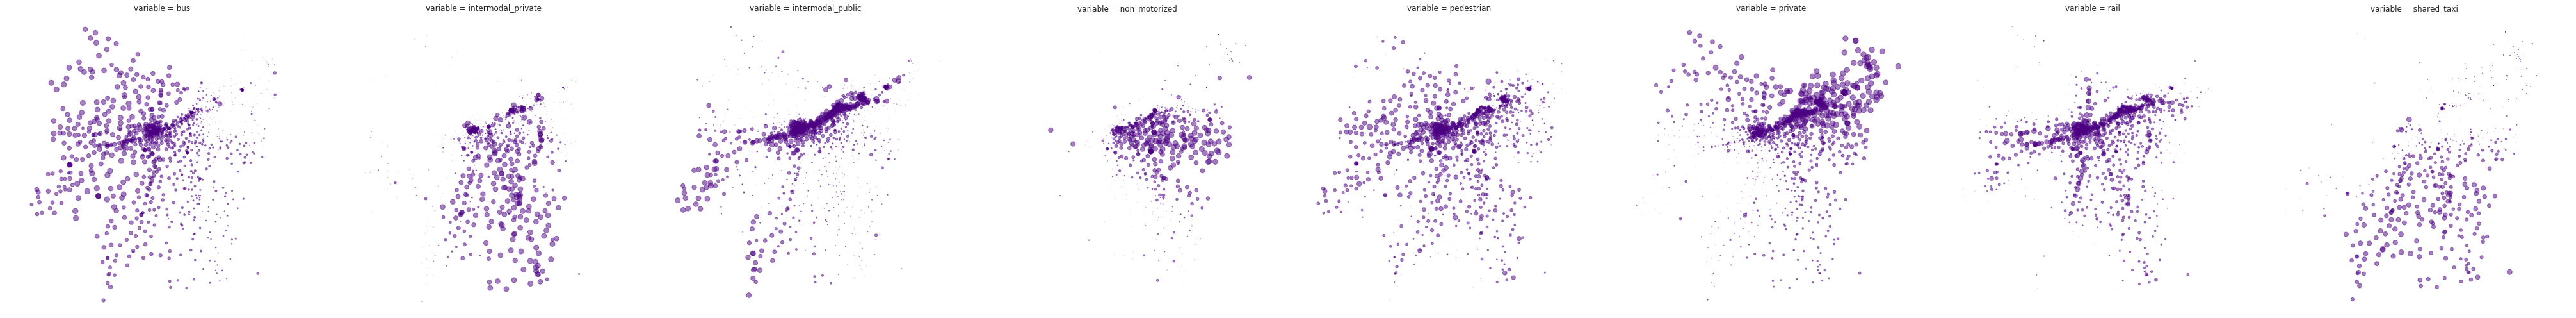

Actual period:  afternoon_valley
Matrix shape: (1375, 194067)


Getting initial W from H_init


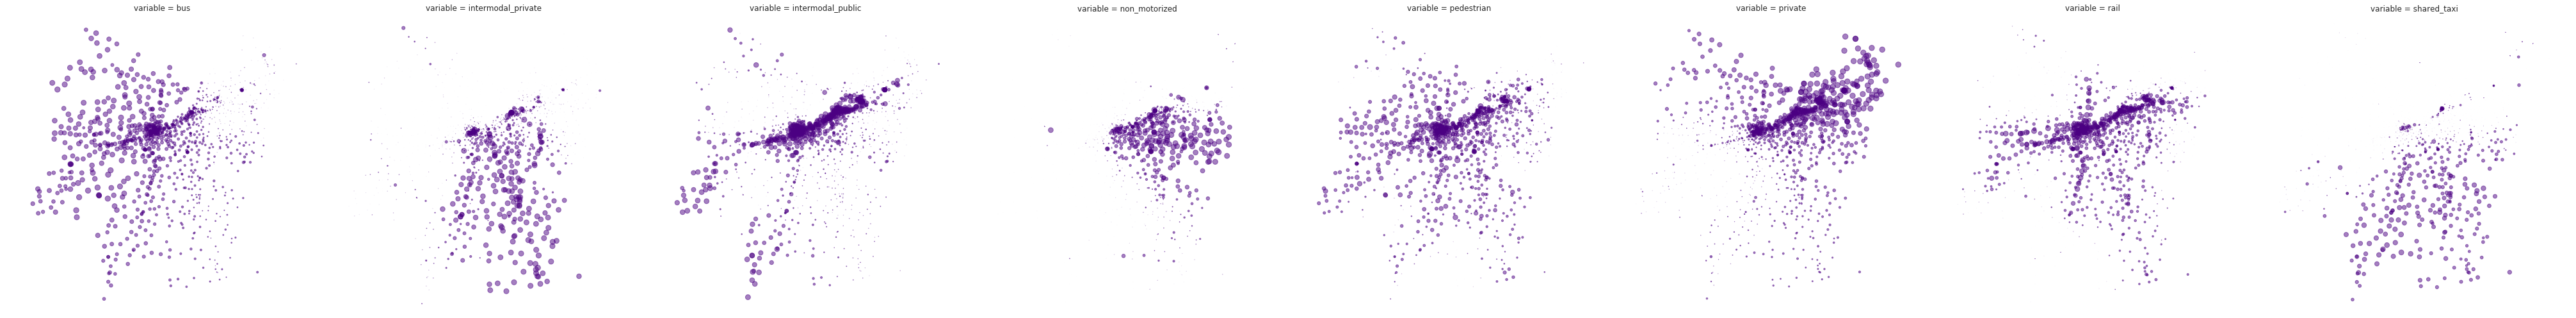

Actual period:  morning_peak_1
Matrix shape: (1375, 150982)


Getting initial W from H_init


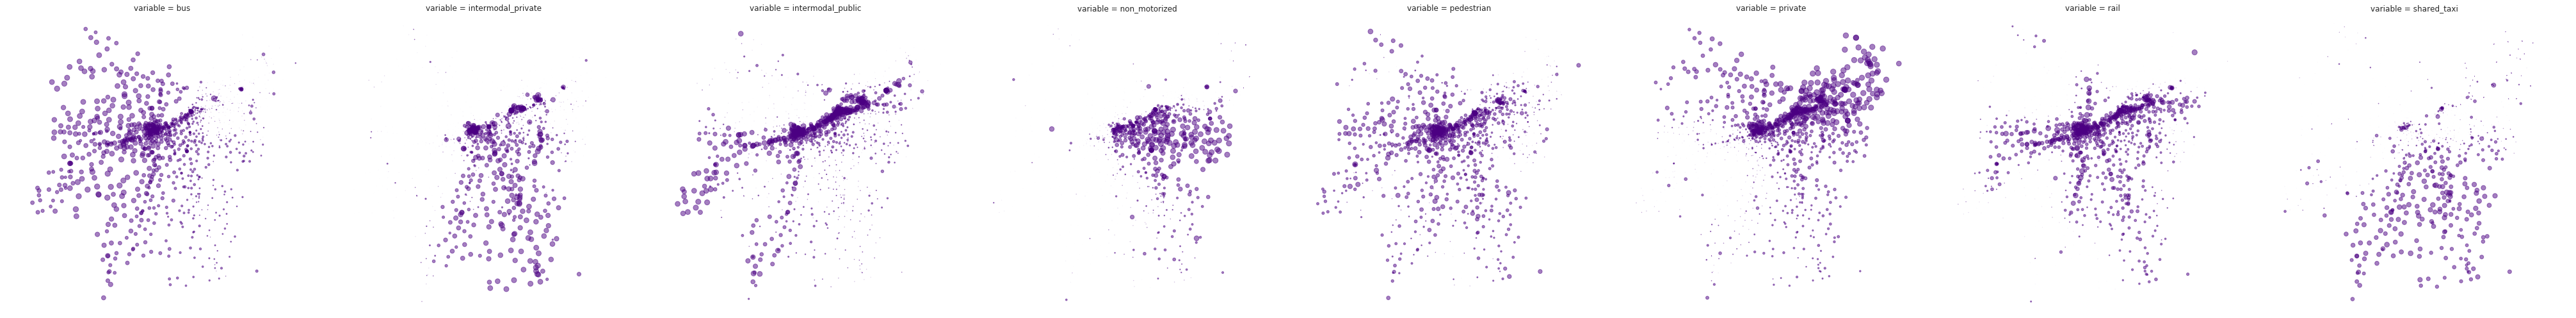

Actual period:  morning_peak_2
Matrix shape: (1375, 155971)


Getting initial W from H_init


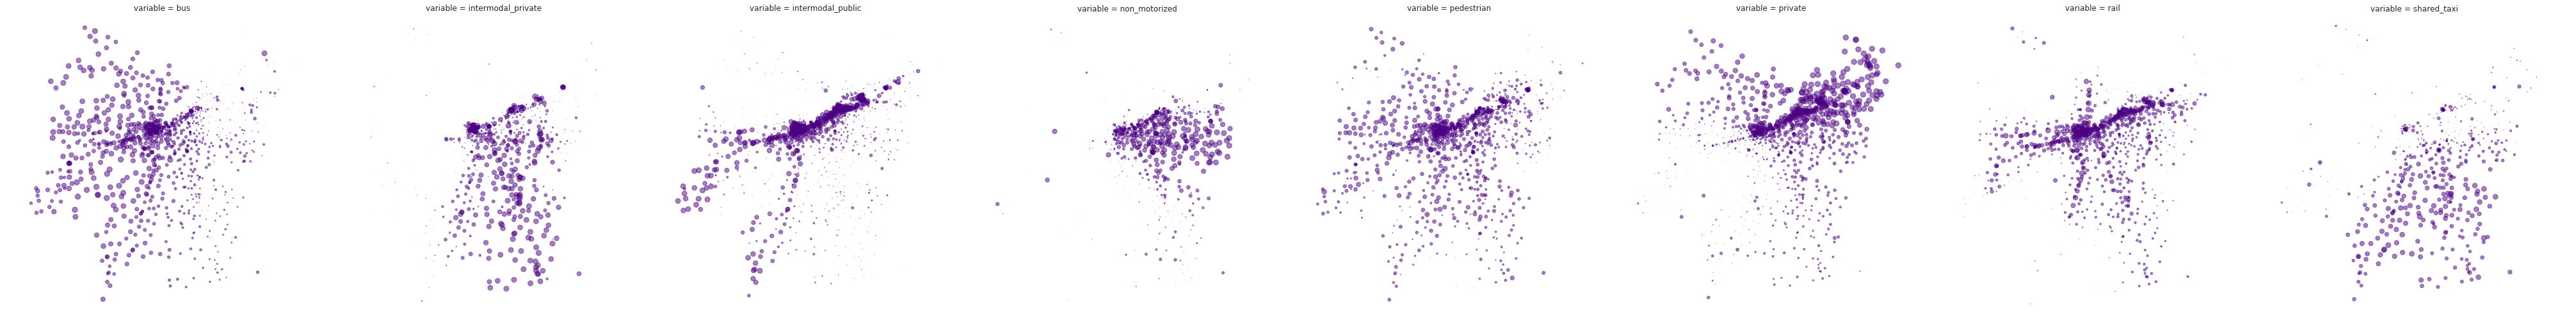

Actual period:  morning_valley
Matrix shape: (1375, 175315)


Getting initial W from H_init


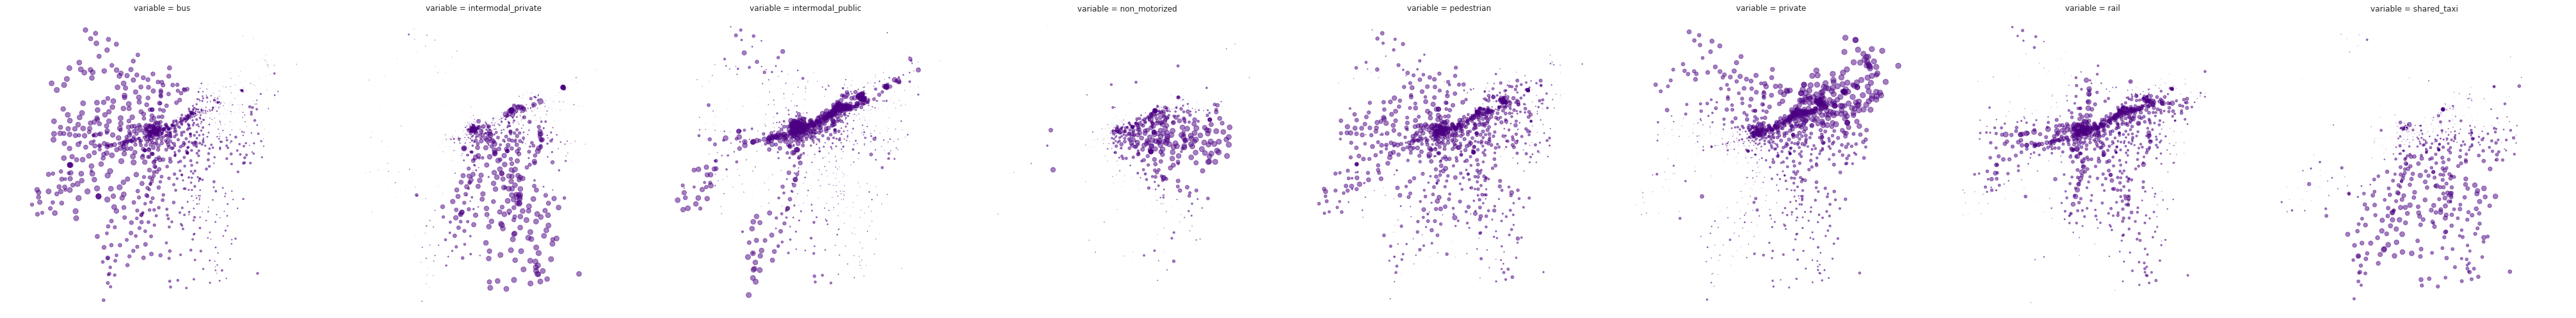

Actual period:  night
Matrix shape: (1375, 145024)


Getting initial W from H_init


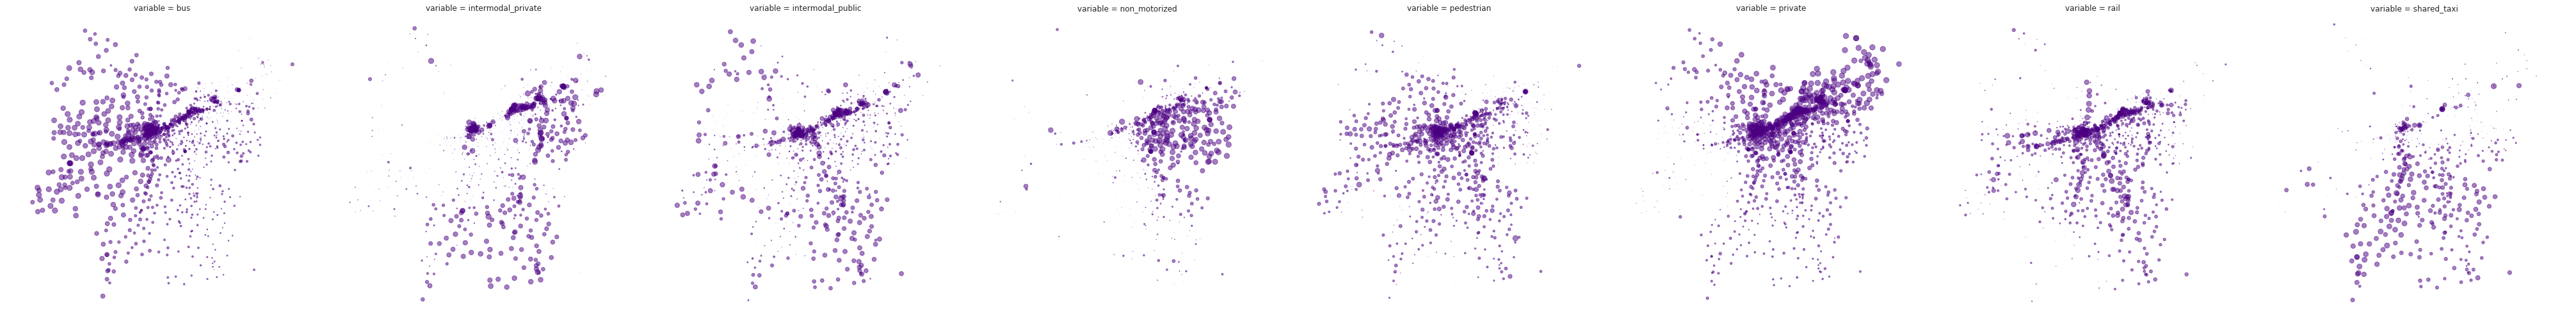

Actual period:  night_valley
Matrix shape: (1375, 155886)


Getting initial W from H_init


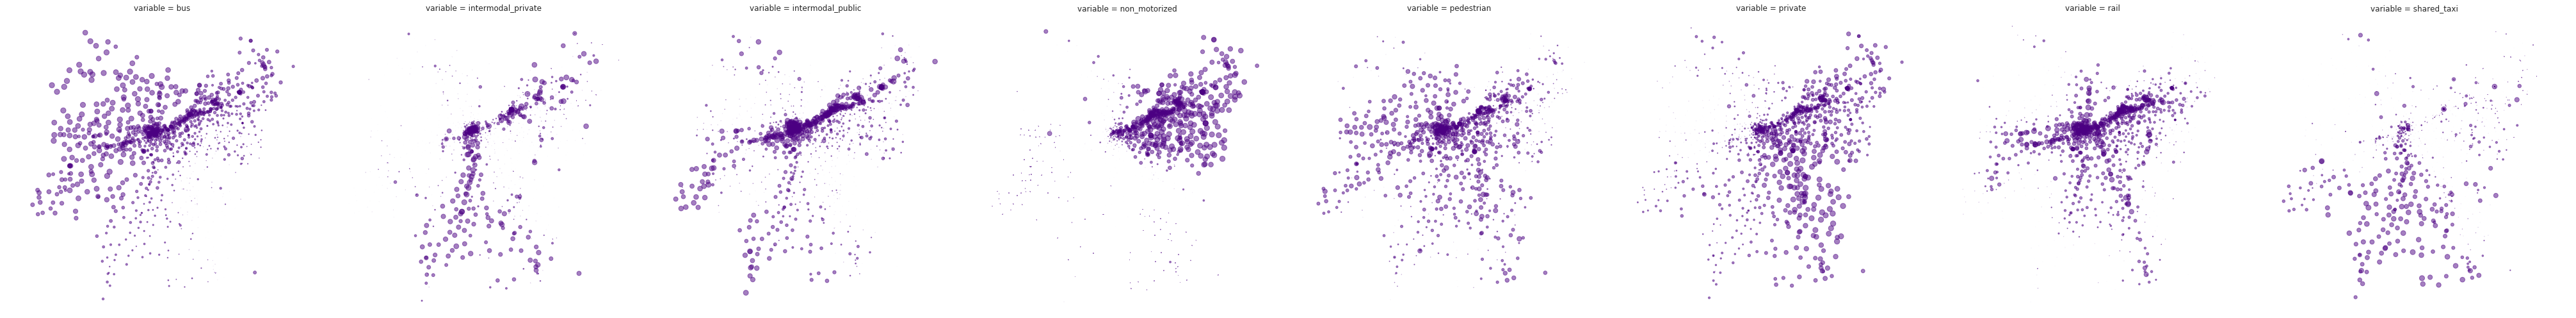

In [ ]:
listOfposteriors_nmf_byPeriod = {}
for period in periods:
    print('Actual period: ', period)
    flow_posteriors = (pd.read_json('2020_results/modal_partition_zones_{}.json.gz'.format(period), 
                  compression='gzip', orient='records', lines=True)
                       .set_index(['origin_zone', 'destination_zone'])
                       .drop(columns=['period'])
                      )
    
    waypoint_periods = waypoint_index[waypoint_index.period == period]
    #to_factorize = csr_matrix(TfidfTransformer(norm='l1').fit_transform(waypoints[waypoint_periods.index]).T, copy=True)
    #to_factorize[to_factorize > 0] = 1

    zone_features = (waypoint_periods
        .join(zone_income, on='origin_zone', how='inner')
        .rename(columns={'mean_home_income': 'origin_income'})
        .join(zone_income, on='destination_zone', how='inner')
        .rename(columns={'mean_home_income': 'destination_income'})
        .join(zone_distances, on=['origin_zone', 'destination_zone'], how='inner')
        .join(zone_mindist.add_prefix('origen_'), on='origin_zone', how='inner')
        .join(zone_mindist.add_prefix('destino_'), on='destination_zone', how='inner')
        .pipe(lambda x: x[x['origin_zone']!=x['destination_zone']])
    )
    
    waypoint_periods_distances = waypoint_periods.merge(zone_inverse_distance).set_index('index')
    waypoint_periods_distances = waypoint_periods_distances.loc[zone_features.index]
    to_factorize = csr_matrix(TfidfTransformer(norm='l1').fit_transform(waypoints[waypoint_periods_distances.index]), copy=True)
    to_factorize = hstack([to_factorize, csr_matrix([waypoint_periods_distances['distance'].to_numpy()]).T], format='csr').T    

    # Prior will be the EOD    
    zone_priors = mnlogit.predict(zone_features.set_index(['origin_zone', 'destination_zone']))
    zone_priors.columns = mnlogit_column_names
    
    print('Matrix shape:', to_factorize.shape)
    evidences_nmf = []
    posteriors_nmf = [flow_posteriors]
    total_values = posteriors_nmf[0].shape[0]*posteriors_nmf[0].shape[1]
    tol = 1e-7
    # Only 2 iterations of multiplicative update
    max_iter = 2   
    actual_val=0
    W_init = None
    for i in tqdm(range(100)):
        # Flow_posteriors has some NaN values 
        H_init = flow_posteriors[mnlogit_column_names].T.fillna(0.25).to_numpy() # Initial H matrix is the Posterior
        

        #avg = np.sqrt(to_factorize.mean() / len(mnlogit_column_names))
        #rng = check_random_state(42)
        #W_init = np.full((len(towers), len(mnlogit_column_names)), avg) #avg * rng.randn(len(towers), len(mnlogit_column_names))
        if i==0:
            # Initial W is retrieved from H_init
            print("Getting initial W from H_init")
            _nmf = NMF(n_components=len(mnlogit_column_names), init='random', solver='mu', verbose=0, tol=1e-04, random_state=2, max_iter = 50)
            _nmf.n_components_ = H_init.shape[0]
            _nmf.components_ = H_init
            _nmf.n_iter_ = 50
            W_init = _nmf.transform(to_factorize)
            W_init_tm = np.delete(W_init,-1, axis=0)
            tower_mode = pd.DataFrame(normalize(W_init_tm, norm='l1') , index=towers.index.tolist(), columns= flow_posteriors.columns)
            tower_mode.index.name = 'tower'
            
            # plot the tower factorization for inspection
            sup_tower_components = (tower_mode
                                    .reset_index()
                                    .pipe(lambda x: pd.melt(x, id_vars='tower')))
            sup_scaler = MinMaxScaler(feature_range=(sup_min_bubble_size, sup_max_bubble_size))
            sup_scaler.fit(np.sqrt(sup_tower_components.value.values.reshape(-1, 1)))
            sup_geodf = gpd.GeoDataFrame(sup_tower_components.join(towers, on='tower'), crs={'init': 'epsg:4326'})
            g = sns.FacetGrid(data=sup_geodf, col='variable', height=7, aspect=1, sharex=False, sharey=False)
            g.map_dataframe(plot_component, 'value', scaler=sup_scaler)       
            plt.show()
        else:
            # In the next iterations W_init is the previous W
            W_init = W_nmf.copy()
        
        nmf = NMF(n_components=len(mnlogit_column_names), init='custom', solver='mu', verbose=0, tol=1e-04, random_state=42, max_iter = max_iter)
        W_nmf = nmf.fit_transform(to_factorize, W=W_init.copy(), H=H_init.copy())   
        
        '''tower_mode = pd.DataFrame(normalize(W_nmf, norm='l1') , index=towers.index.tolist(), columns= flow_posteriors.columns)
        tower_mode.index.name = 'tower'
            
        # plot the tower factorization for inspection
        sup_tower_components = (tower_mode
                                .reset_index()
                                .pipe(lambda x: pd.melt(x, id_vars='tower')))
        sup_scaler = MinMaxScaler(feature_range=(sup_min_bubble_size, sup_max_bubble_size))
        sup_scaler.fit(np.sqrt(sup_tower_components.value.values.reshape(-1, 1)))
        sup_geodf = gpd.GeoDataFrame(sup_tower_components.join(towers, on='tower'), crs={'init': 'epsg:4326'})
        g = sns.FacetGrid(data=sup_geodf, col='variable', height=7, aspect=1, sharex=False, sharey=False)
        g.map_dataframe(plot_component, 'value', scaler=sup_scaler)       
        plt.show()'''
        
        flow_evidence_nmf = (pd.DataFrame(nmf.components_.T , 
                                  index=waypoint_periods_distances.index, 
                                  columns=mnlogit_column_names)
                     .join(waypoint_periods)
                     .set_index(['origin_zone', 'destination_zone'])
                     .drop(['index', 'period'], axis=1)
        )
        
        flow_priors = zone_priors.loc[flow_evidence_nmf.index]
        # Update posterior
        denominator = flow_priors.mul(flow_evidence_nmf).sum(axis=1)
        flow_posteriors = flow_evidence_nmf.mul(flow_priors).div(denominator, axis='index')
        
        posteriors_nmf.append(flow_posteriors.copy())   
        similar_values = np.sum(np.isclose(posteriors_nmf[i-1][mnlogit_column_names],
                                           posteriors_nmf[i][mnlogit_column_names], rtol=tol, atol=tol))

        if similar_values/total_values*100-actual_val<0.1 and i>10:
            break
        actual_val = similar_values/total_values*100
    listOfposteriors_nmf_byPeriod[period] = posteriors_nmf


In [ ]:
tol = 1e-7
colors = plt.cm.magma(np.linspace(0,1,5))

for period, value in listOfposteriors_nmf_byPeriod.items():
    _, ax = plt.subplots(figsize=(12,8))
    val_t = []
    for i in range(1,len(value)):
        total_values_t = value[0].shape[0]*value[0].shape[1]
        similar_values_t = np.sum(np.isclose(value[i-1][mnlogit_column_names],
                                           value[i][mnlogit_column_names], rtol=tol, atol=tol))
        val_t.append(similar_values_t/total_values_t*100)
    for j,col in enumerate(value[0].columns):
        val = []
        for i in range(1,len(value)):
            total_values = value[0].shape[0]
            similar_values = np.sum(np.isclose(value[i-1][col],
                                               value[i][col], rtol=tol, atol=tol))
            val.append(similar_values/total_values*100)
        ax.plot(np.arange(1, len(val)+1), val, label=col, color='gray', alpha=0.8)
        plt.annotate(col, xy=(0.95, val[-1]), xytext=(8, 0), color='gray', alpha=0.8,
                    xycoords=('axes fraction', 'data'), textcoords='offset points', size=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot(np.arange(1, len(val_t)+1),val_t, color='black')
    ax.grid(axis='both', alpha=0.7, linestyle='--')
    plt.ylim(0,100)
    plt.xlim(1)
    plt.ylabel('Percentage of similar values (%)', size=16)
    plt.xlabel('Number of iterations', size=16)
    #plt.legend(loc=0)
    plt.title('NMF posterior evolution, {}'.format(period), size=16)
    
    plt.show()
    #plt.savefig('nmf_posterior_evolution_100_{}.png'.format(period))
    plt.close()

In [ ]:
# plot just a modal partition
period = periods[0]
# n is the iteration
n = 0
plot_modal_partition(listOfposteriors_nmf_byPeriod[period][n].mul(period_matrices.loc[period], axis='index')   , period, 'Posterior iteration {}'.format(n))

In [ ]:
# plot just a modal partition
period = periods[0]
# n is the iteration
n = (len(listOfposteriors_nmf_byPeriod[period]))-1
plot_modal_partition(listOfposteriors_nmf_byPeriod[period][n].mul(period_matrices.loc[period], axis='index')   , period, 'Posterior iteration {}'.format(n))

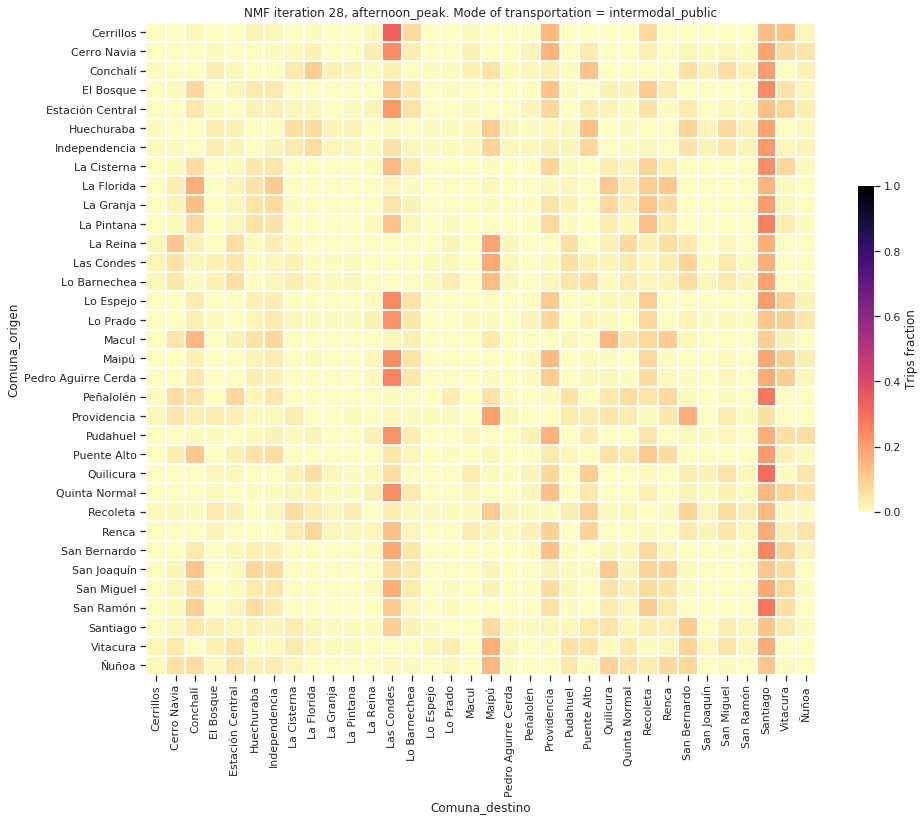

In [27]:
# plot just one heatmap
tipo = 'intermodal_public'
plot_heatmap(listOfposteriors_nmf_byPeriod[period][n].mul(period_matrices.loc[period], axis='index') , tipo, 'NMF iteration {}, {}'.format(n, period))

In [29]:
# Plot all modal partitions and heatmaps
#prefix norm_ refers to the use of .mul(period_matrices.loc[period]
for period in periods:
    print(period)
    for i in tqdm(range(0,len(listOfposteriors_nmf_byPeriod[period]))):
        #for tipo in mnlogit_column_names:
            #print(tipo)
            #plot_heatmap(listOfposteriors_nmf_byPeriod[period][i], tipo, 'NMF iteration {}, {}'.format(i, period),
            #             save_as='heatmaps_100/{}_{}_{}.png'.format(tipo, period, i))
            
            #plot_heatmap(listOfposteriors_nmf_byPeriod[period][i].mul(period_matrices.loc[period], axis='index'),
            #             tipo, 'NMF iteration {}, {}'.format(i, period), save_as='heatmaps/norm_{}_{}_{}.png'.format(tipo, period, i))
            
        #plot_modal_partition(listOfposteriors_nmf_byPeriod[period][i], period,
        #    'Posterior iteration {}'.format(i), save_as='posteriors_100/{}_{}.png'.format(period, i))
        plot_modal_partition(listOfposteriors_nmf_byPeriod[period][i].mul(period_matrices.loc[period], axis='index'), period,
            'Posterior iteration {}'.format(i), save_as='posteriors_v2/norm_{}_{}.png'.format(period, i))

afternoon_peak



afternoon_valley



morning_peak_1



morning_peak_2



morning_valley



night



night_valley


In [31]:
# create gifs
for period in tqdm(periods):
    #for tipo in mnlogit_column_names:
    #    files = 'heatmaps/{}_{}_*.png'.format(tipo,period)
    #    files_norm = 'heatmaps_100/norm_{}_{}_*.png'.format(tipo,period)
    #    file_out =  'heatmaps/{}_{}.gif'.format(tipo,period)
    #    file_out_norm =  'heatmaps_100/norm_{}_{}.gif'.format(tipo,period)
    #    !convert -delay 10 -loop 0 -resize 80% $(ls -rt $files) $file_out
    #    !convert -delay 10 -loop 0 -resize 80% $(ls -rt $files_norm) $file_out_norm
    #files = 'posteriors/{}_*.png'.format(period)
    files_norm = 'posteriors_v2/norm_{}_*.png'.format(period)
    #file_out =  'posteriors/{}.gif'.format(period)
    file_out_norm =  'posteriors_v2/norm_{}.gif'.format(period)
    #!convert -delay 10 -loop 0 -resize 80% $(ls -rt $files) $file_out
    !convert -delay 10 -loop 0 -resize 80% $(ls -rt $files_norm) $file_out_norm